In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

import random
from collections import defaultdict

%matplotlib inline

In [2]:
DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness"

In [3]:
YEAR = 2019
raw_tournament_df = pd.read_csv(f"{DATA_DIR}/output/teams.csv")
tournament_df = raw_tournament_df[raw_tournament_df["Season"] == YEAR]
tournament_df

,TeamID,TeamName,Season,OwnScore_Zscore,OwnFGM_Zscore,OwnFGA_Zscore,OwnFGM3_Zscore,OwnFGA3_Zscore,OwnFTM_Zscore,OwnFTA_Zscore,...,OppBlk_Zscore,OppPF_Zscore,Offense,Dominance,OffCompetition,DefCompetition,Competition,Seed,SeedInt,Wins
0,1101,Abilene Chr,2019,-0.021108,0.099135,-0.019743,-0.123181,-0.500113,-0.100465,-0.138523,...,0.120204,-0.105065,-0.396929,0.354714,-0.060151,0.059062,-0.119213,Y15,15,0.0
42,1113,Arizona St,2019,0.540309,0.268478,0.131485,-0.086636,-0.172354,0.760601,0.960675,...,-0.031845,0.944549,0.520279,0.560339,0.044954,-0.041268,0.086222,X11a,11,0.0
54,1120,Auburn,2019,0.668713,0.429304,0.414780,1.242913,1.340961,-0.034461,-0.088787,...,-0.139864,-0.231429,0.338709,0.998717,0.086323,-0.080514,0.166837,Y05,5,4.0
65,1124,Baylor,2019,0.171236,0.227180,0.078155,0.178541,0.292148,-0.085758,-0.015168,...,0.401352,0.011150,-0.196518,0.538990,0.060677,-0.088995,0.149672,X09,9,1.0
73,1125,Belmont,2019,1.075292,1.074748,0.591580,0.807501,0.866679,-0.143537,-0.234621,...,0.048870,-0.417461,1.048486,1.102099,0.007313,0.063784,-0.056471,W11a,11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,1439,Virginia Tech,2019,0.306598,0.184308,-0.506046,0.623667,0.283049,-0.033358,-0.241701,...,-0.311852,-0.284286,-0.445517,1.058713,0.060724,-0.078557,0.139281,W04,4,2.0
1055,1449,Washington,2019,-0.083146,-0.124663,-0.534150,-0.050845,-0.091130,0.011967,-0.038558,...,-0.564492,0.017061,-0.796668,0.630376,0.046538,-0.044687,0.091225,Y09,9,1.0
1107,1458,Wisconsin,2019,-0.115887,0.266530,-0.156093,0.051941,-0.394714,-0.485600,-0.393875,...,0.138245,-0.059321,-1.044888,0.813113,0.080123,-0.113615,0.193738,Z05,5,0.0
1112,1459,Wofford,2019,0.598993,0.613610,0.143320,0.656850,0.260074,-0.270259,-0.296197,...,-0.306722,-0.501728,0.071653,1.126333,0.047536,0.005411,0.042125,Y07,7,1.0


In [4]:
# https://www.kaggle.com/c/ncaam-march-mania-2021/data
# Get slots, and order with play ins first
slots_df = pd.read_csv(f"{DATA_DIR}/MNCAATourneySlots.csv")
slots_df = slots_df[slots_df["Season"] == YEAR]
slots_df = pd.concat([
    slots_df[~slots_df["Slot"].str.startswith("R")],
    slots_df[slots_df["Slot"].str.startswith("R")]
])
slots_df

,Season,Slot,StrongSeed,WeakSeed
2247,2019,W11,W11a,W11b
2248,2019,W16,W16a,W16b
2249,2019,X11,X11a,X11b
2250,2019,X16,X16a,X16b
2184,2019,R1W1,W01,W16
...,...,...,...,...
2242,2019,R4Y1,R3Y1,R3Y2
2243,2019,R4Z1,R3Z1,R3Z2
2244,2019,R5WX,R4W1,R4X1
2245,2019,R5YZ,R4Y1,R4Z1


In [5]:
games_df = pd.read_csv(f"{DATA_DIR}/output/games_training.csv")
games_df

,Season,TeamID_A,TeamID_B,OwnScore_Zscore_A,OppScore_Zscore_A,OffCompetition_A,DefCompetition_A,OwnScore_Zscore_B,OppScore_Zscore_B,OffCompetition_B,DefCompetition_B,Win_A
0,2003,1104,1328,0.144799,-0.335313,0.066613,-0.086731,0.207507,-0.863963,0.063014,-0.075414,True
1,2003,1328,1400,0.207507,-0.863963,0.063014,-0.075414,0.935597,-0.181307,0.070846,-0.076583,False
2,2003,1328,1400,0.207507,-0.863963,0.063014,-0.075414,0.935597,-0.181307,0.070846,-0.076583,False
3,2003,1281,1328,0.297116,-0.342031,0.080871,-0.078838,0.207507,-0.863963,0.063014,-0.075414,True
4,2003,1328,1329,0.207507,-0.863963,0.063014,-0.075414,-0.064060,-0.740947,0.057988,-0.072412,False
...,...,...,...,...,...,...,...,...,...,...,...,...
92827,2020,1460,1464,0.580601,0.198484,-0.033763,0.061707,-0.105439,0.096059,-0.026838,0.058533,False
92828,2020,1227,1460,-0.313002,-0.164300,-0.023355,0.048164,0.580601,0.198484,-0.033763,0.061707,True
92829,2020,1227,1460,-0.313002,-0.164300,-0.023355,0.048164,0.580601,0.198484,-0.033763,0.061707,True
92830,2020,1232,1460,0.095964,-0.190164,-0.009144,-0.020654,0.580601,0.198484,-0.033763,0.061707,True


In [6]:
# Train predictor based on derived offense and quality metrics
predict_df = games_df[[
    "OwnScore_Zscore_A", "OwnScore_Zscore_B",
    "OppScore_Zscore_A", "OppScore_Zscore_B",   
    "OffCompetition_A", "OffCompetition_B",
    "DefCompetition_A", "DefCompetition_B",    
]]

scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(predict_df),
    columns=predict_df.columns
) 

reg = LogisticRegression().fit(
    data_scaled,
    games_df[["Win_A"]]
)
reg.score(
    data_scaled,
    games_df[["Win_A"]]
), reg.coef_

/Users/jameswhedbee/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(0.7465098241985523,
 array([[ 0.93305539, -0.9247616 , -0.84147495,  0.88028553,  0.38889109,
         -0.3745633 , -0.40932373,  0.39900333]]))

In [7]:
# See p-values for model
import statsmodels.api as sm
logit_model=sm.Logit(
    games_df[["Win_A"]].astype(int),
    data_scaled,
)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.497845
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Win_A   No. Observations:                92832
Model:                          Logit   Df Residuals:                    92824
Method:                           MLE   Df Model:                            7
Date:                Sat, 13 Mar 2021   Pseudo R-squ.:                  0.2813
Time:                        15:45:21   Log-Likelihood:                -46216.
converged:                       True   LL-Null:                       -64308.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
OwnScore_Zscore_A     0.9318      0.010     89.763      0.000       0.911       0.952
OwnScore

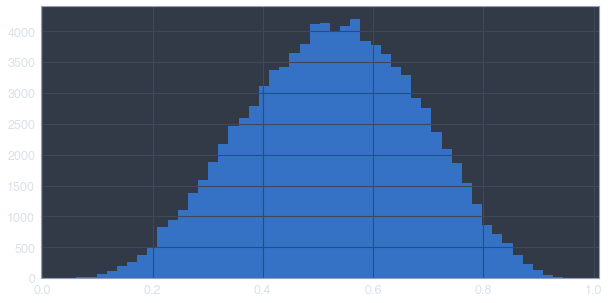

In [8]:
# Sanity check probability distribution
plt.figure(figsize=(10,5));
probs = [
    a for a, b in reg.predict_proba(predict_df)
]
plt.hist(probs, bins=50);

In [9]:
average_team = raw_tournament_df.mean().to_dict()
average_team

{'TeamID': 1294.6272084805653,
 'Season': 2011.095406360424,
 'OwnScore_Zscore': 0.3944827165002876,
 'OwnFGM_Zscore': 0.3488975689960947,
 'OwnFGA_Zscore': 0.07891188350882043,
 'OwnFGM3_Zscore': 0.11510082288565864,
 'OwnFGA3_Zscore': 0.010426529442926859,
 'OwnFTM_Zscore': 0.17838491765557618,
 'OwnFTA_Zscore': 0.15616550986481262,
 'OwnOR_Zscore': 0.08443204682339014,
 'OwnDR_Zscore': 0.24766566243169602,
 'OwnAst_Zscore': 0.3065619895889596,
 'OwnTO_Zscore': -0.1730142383529098,
 'OwnStl_Zscore': 0.1406582512564568,
 'OwnBlk_Zscore': 0.19693049733302553,
 'OwnPF_Zscore': -0.15862098523579035,
 'OppScore_Zscore': -0.32319314544724476,
 'OppFGM_Zscore': -0.25040132986530667,
 'OppFGA_Zscore': 0.017491449766850742,
 'OppFGM3_Zscore': -0.11453451348432366,
 'OppFGA3_Zscore': -0.02126103424745929,
 'OppFTM_Zscore': -0.18083373182626544,
 'OppFTA_Zscore': -0.18412513865374,
 'OppOR_Zscore': -0.046352611926512834,
 'OppDR_Zscore': -0.26915084007441703,
 'OppAst_Zscore': -0.25744151970801

In [10]:
from functools import lru_cache

@lru_cache(maxsize=4096)
def calc_prob(predict_data):
    return reg.predict_proba(scaler.transform([predict_data]))[0][1]

def get_power_rating(team):
    return calc_prob((
            team["OwnScore_Zscore"], average_team["OwnScore_Zscore"],
            team["OppScore_Zscore"], average_team["OppScore_Zscore"],
            team["OffCompetition"], average_team["OffCompetition"],
            team["DefCompetition"], average_team["DefCompetition"],
        ))

In [11]:
def scatter_text(x, y, labelseries, labelsize='large', labelcolor='black', **kwargs):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, **kwargs)
    # Add text besides each point
    offset = 0.01 * (max(x) - min(x))
    for line in range(len(x)):
         p1.text(
             x.iloc[line]+offset, y.iloc[line], 
             labelseries.iloc[line], size=labelsize, color=labelcolor
         )
    return p1

In [12]:
# Best teams of all time
raw_tournament_df["PowerRating"] = raw_tournament_df.apply(get_power_rating, axis=1)
raw_tournament_df["PowerOdds"] = raw_tournament_df["PowerRating"] / (1-raw_tournament_df["PowerRating"])
raw_tournament_df["PowerLogOdds"] = np.log(raw_tournament_df["PowerOdds"])

raw_tournament_df.sort_values(by="PowerRating", ascending=False)[[
    "Season", "TeamName", "Seed", "PowerRating"
]][:25]

,Season,TeamName,Seed,PowerRating
403,2015,Kentucky,Y01,0.956376
223,2019,Duke,W01,0.934345
208,2004,Duke,W01,0.932170
305,2019,Gonzaga,X01,0.931010
612,2005,North Carolina,Z01,0.928365
1030,2019,Virginia,Z01,0.923060
1021,2018,Villanova,W01,0.919527
371,2010,Kansas,Y01,0.919120
369,2008,Kansas,X01,0.918367
335,2013,Indiana,W01,0.917429


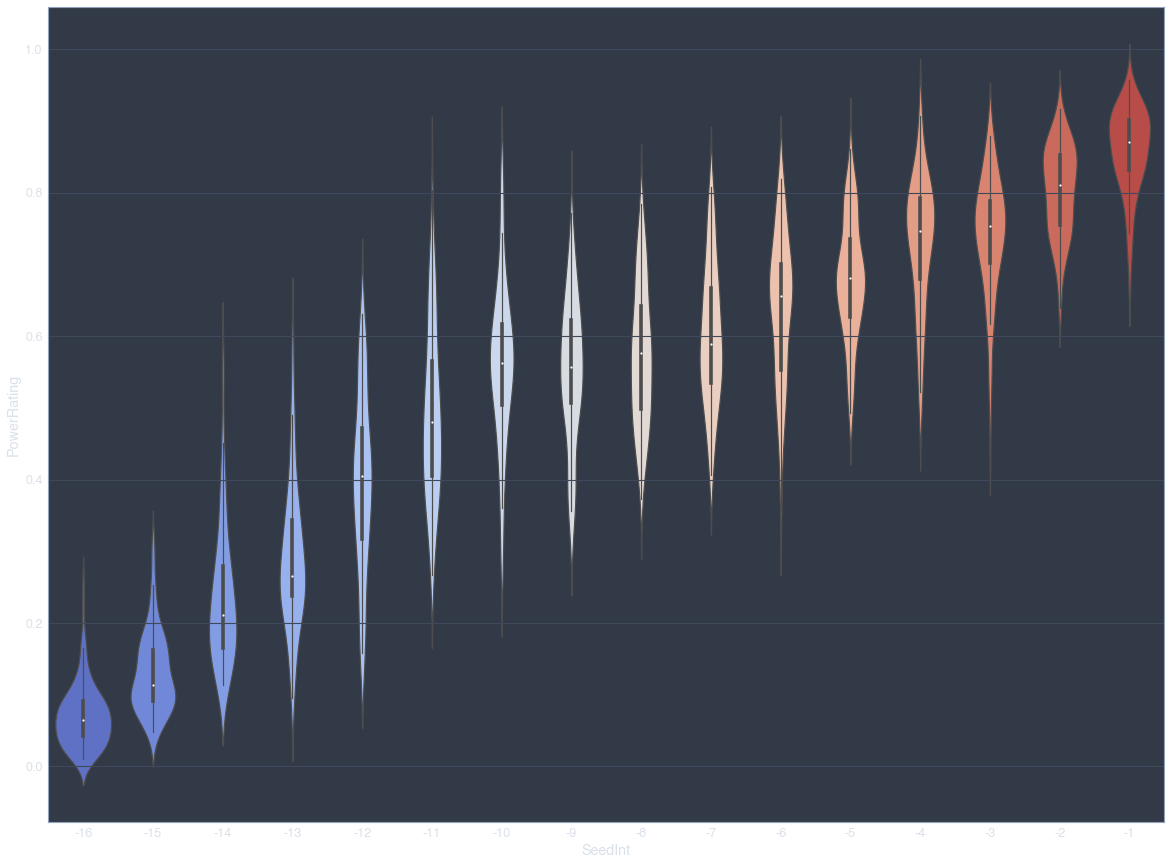

In [13]:
plt.figure(figsize=(20,15));
sns.violinplot(
    x=-raw_tournament_df["SeedInt"],
    y=raw_tournament_df["PowerRating"],
    palette="coolwarm",
);

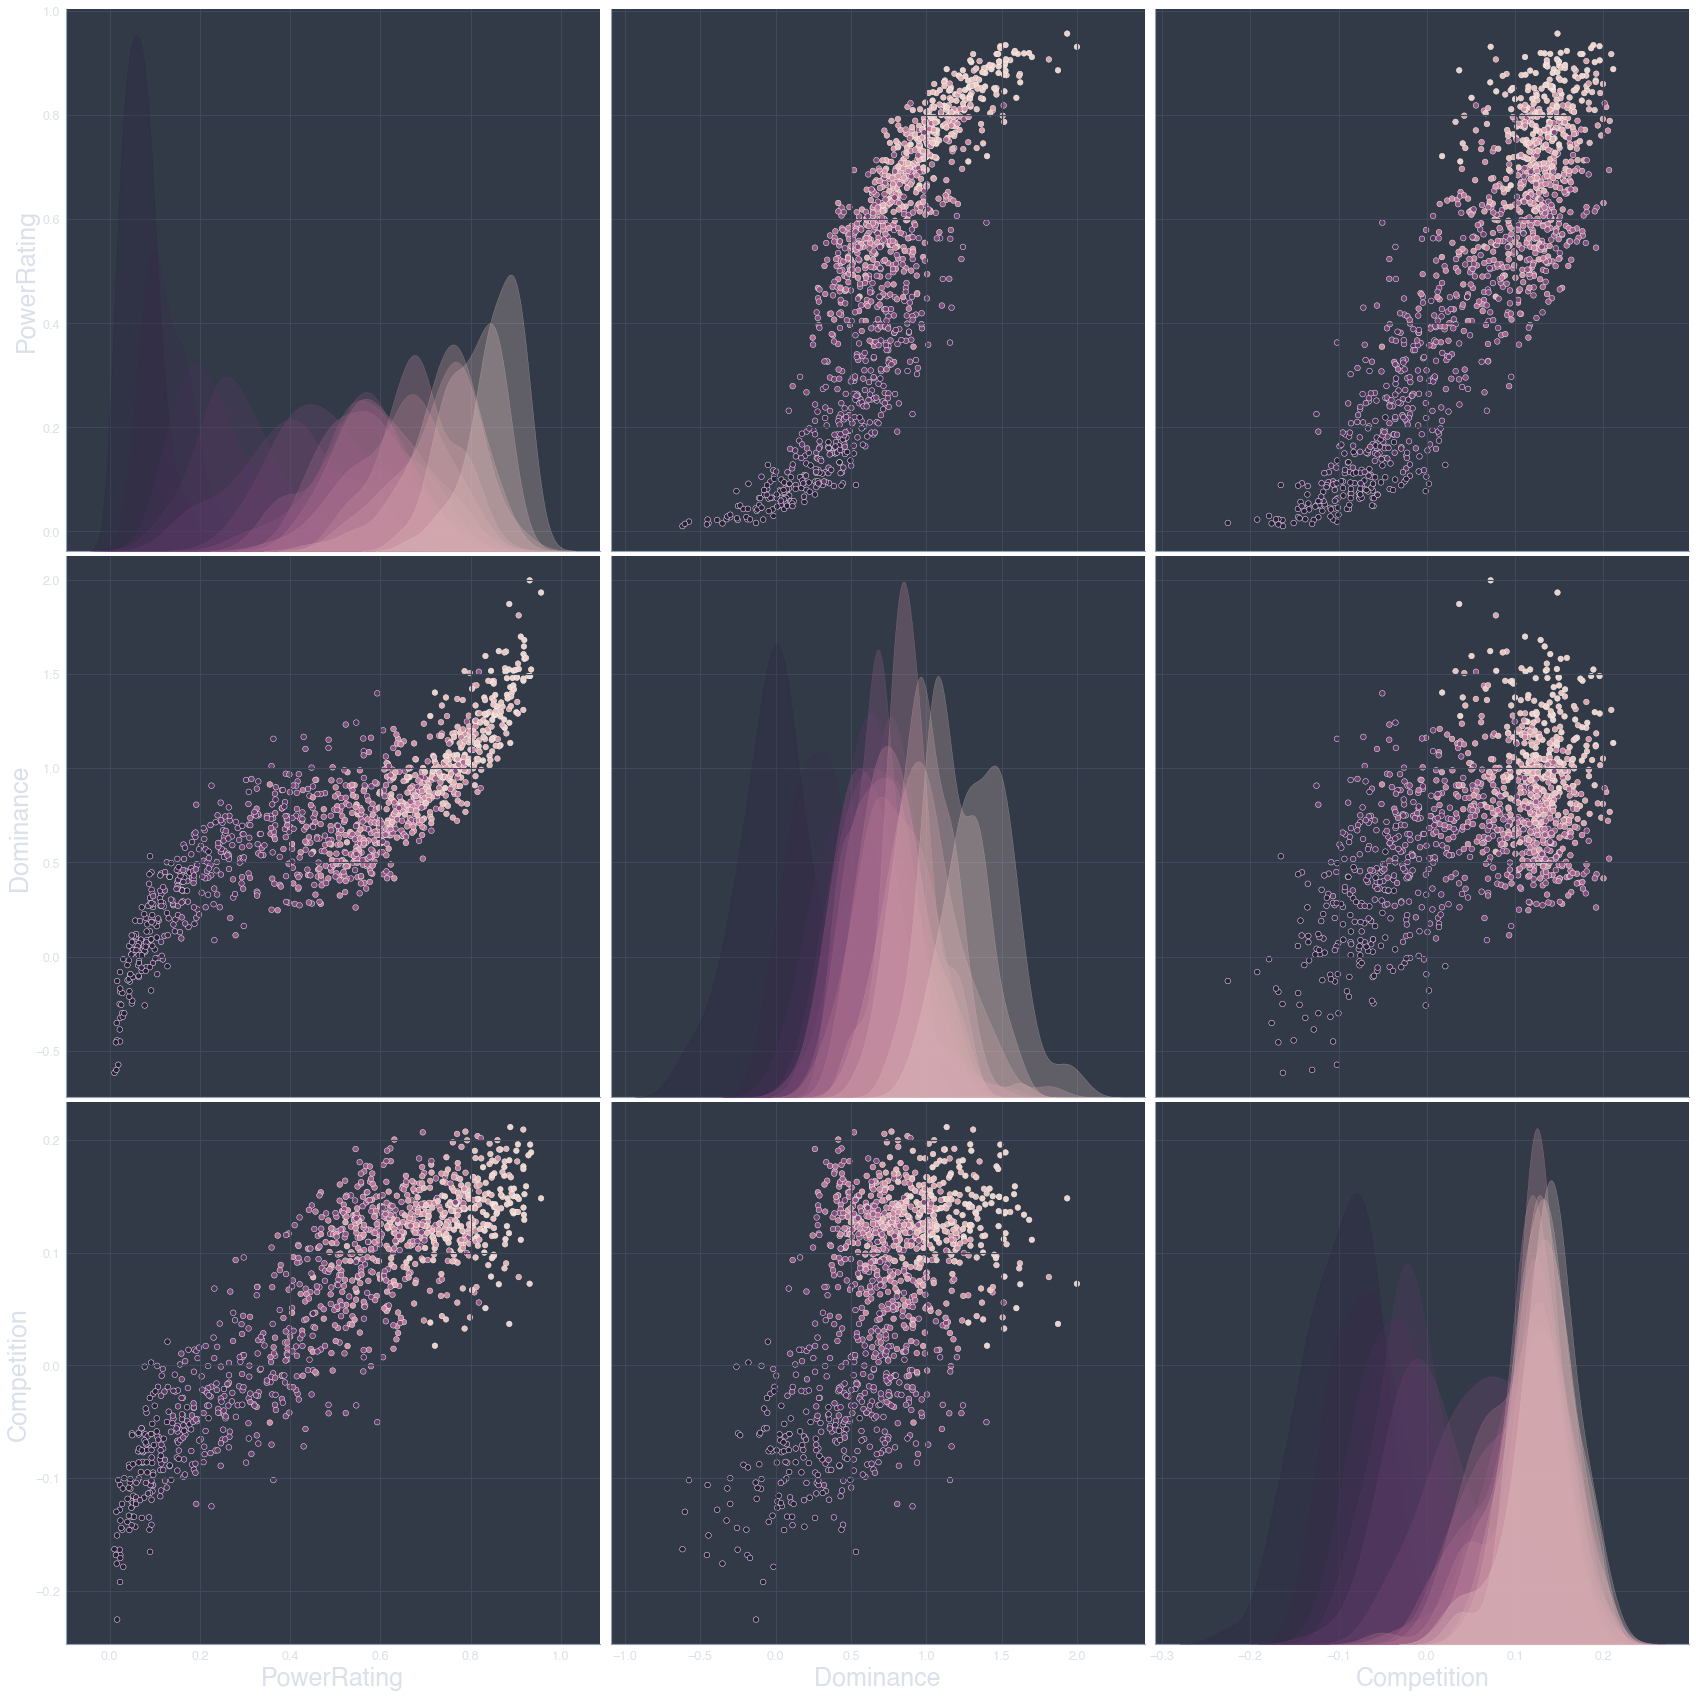

In [37]:
with sns.plotting_context():
    plt.rc('axes', labelsize=25);
    g = sns.pairplot(
        raw_tournament_df[["PowerRating", "Dominance", "Competition", "SeedInt"]],
        hue="SeedInt", height=8
    );
    g._legend.remove();

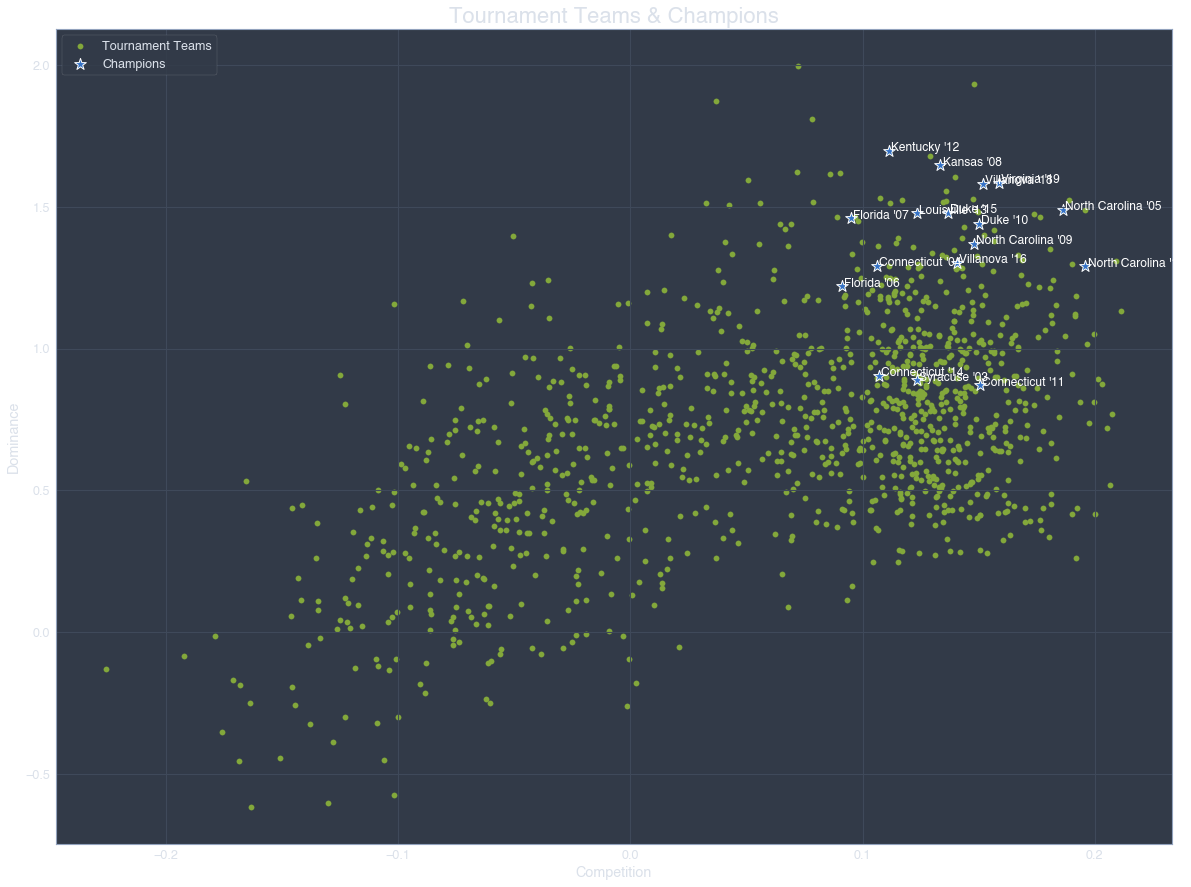

In [15]:
is_champion = raw_tournament_df["Wins"] >= 6
label_series = (
    raw_tournament_df[is_champion]["TeamName"] + " '" +
    raw_tournament_df[is_champion]["Season"].astype(str).str[-2:]
)

plt.figure(figsize=(20,15));
plt.title("Tournament Teams & Champions", fontsize=22)
plt.scatter(
    raw_tournament_df["Competition"],
    raw_tournament_df["Dominance"],
    color='g', label='Tournament Teams'
);
scatter_text(
    raw_tournament_df[is_champion]["Competition"], raw_tournament_df[is_champion]["Dominance"],
    color='b', marker='*', s=150, label='Champions',
    labelseries=label_series,
    labelcolor='white'
);
plt.legend(loc='upper left');

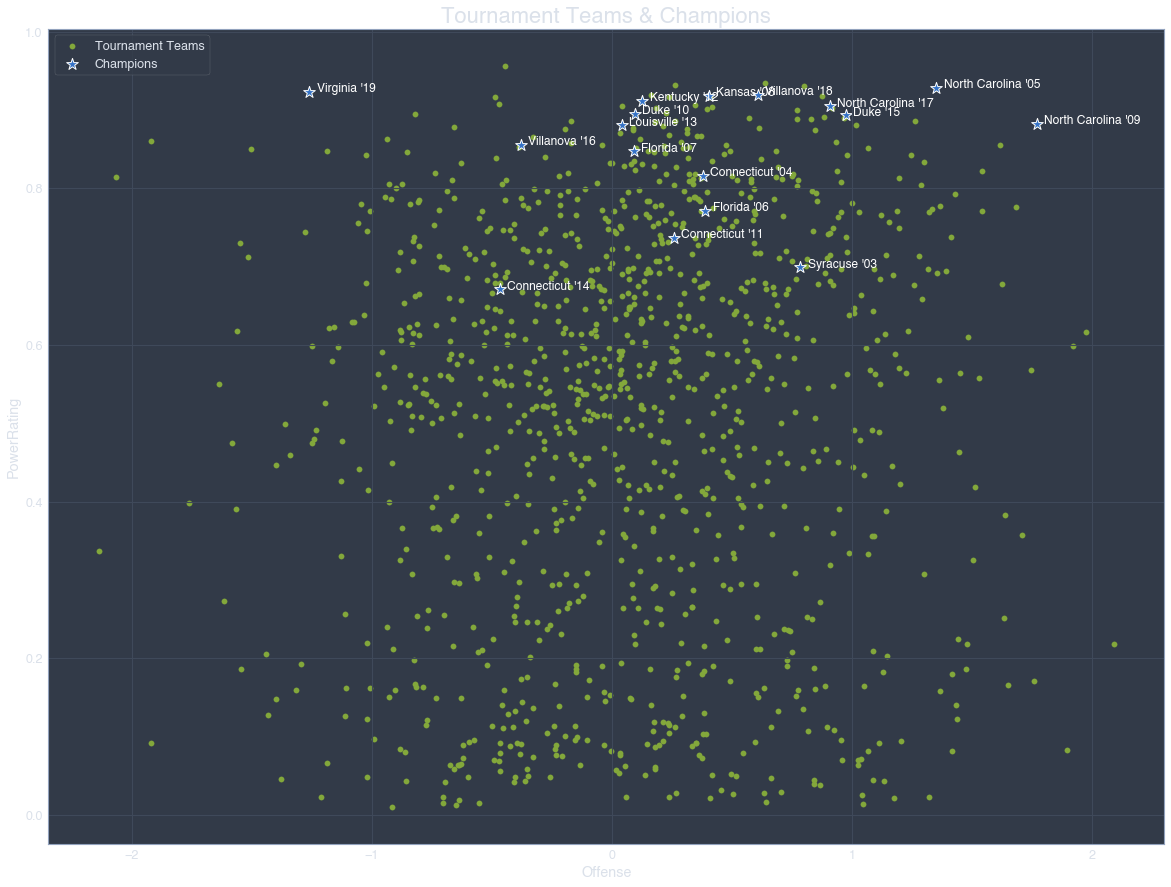

In [16]:
is_champion = raw_tournament_df["Wins"] >= 6
label_series = (
    raw_tournament_df[is_champion]["TeamName"] + " '" +
    raw_tournament_df[is_champion]["Season"].astype(str).str[-2:]
)

plt.figure(figsize=(20,15));
plt.title("Tournament Teams & Champions", fontsize=22)
plt.scatter(
    raw_tournament_df["Offense"],
    raw_tournament_df["PowerRating"],
    color='g', label='Tournament Teams'
);
scatter_text(
    raw_tournament_df[is_champion]["Offense"], raw_tournament_df[is_champion]["PowerRating"],
    color='b', marker='*', s=150, label='Champions',
    labelseries=label_series,
    labelcolor='white'
);
plt.legend(loc='upper left');

In [17]:
power_ratings = {}
slots_wins = defaultdict(lambda: defaultdict(int))
total_stats = defaultdict(lambda: defaultdict(int))
simulation_progression = []
random.seed(19910416)

SIMULATION_ROUNDS = 10000
SIM_MOD = SIMULATION_ROUNDS / 10
TOP_N = 5
for i in tqdm(range(SIMULATION_ROUNDS)):
    # INITIALIZE BRACKET (will be updated durign simulation)
    slots_dict = {
        row["Seed"]: row
        for _, row in tournament_df.iterrows()
    }
    
    for _, r in slots_df.iterrows():
        team_a = slots_dict[r["StrongSeed"]]
        team_b = slots_dict[r["WeakSeed"]]
        predict_data = (
            team_a["OwnScore_Zscore"], team_b["OwnScore_Zscore"],
            team_a["OppScore_Zscore"], team_b["OppScore_Zscore"],
            team_a["OffCompetition"], team_b["OffCompetition"],
            team_a["DefCompetition"], team_b["DefCompetition"],
        )
        prob = calc_prob(predict_data)
        winning_team = team_a if random.random() < prob else team_b
        slots_dict[r["Slot"]] = winning_team
        slots_wins[r["Slot"]][winning_team["TeamID"]] += 1
        total_stats[winning_team["TeamID"]]["wins"] += 1
        if r["Slot"][1] == "3":
            total_stats[winning_team["TeamID"]]["elite8"] += 1
        if r["Slot"][1] == "4":
            total_stats[winning_team["TeamID"]]["final4"] += 1
        
        # Get "difficulty" by looking at opposing power ratings
        power_a = get_power_rating(team_a)
        power_ratings[team_a["TeamID"]] = power_a
        total_stats[team_b["TeamID"]]["opp_power"] += power_a
        total_stats[team_b["TeamID"]]["opp_power_count"] += 1
        
        power_b = get_power_rating(team_b)
        power_ratings[team_b["TeamID"]] = power_b
        total_stats[team_a["TeamID"]]["opp_power"] += power_b
        total_stats[team_a["TeamID"]]["opp_power_count"] += 1
    
    # last winning team is champion
    total_stats[winning_team["TeamID"]]["championships"] +=1
    
    # Track top teams
    if (len(total_stats) > TOP_N) and ((i + 1) % SIM_MOD == 0):
        teams_by_championships = sorted(
            total_stats.items(), key=lambda x: x[1]["championships"], reverse=True
        )
        for team_id, stats in teams_by_championships[:TOP_N]:
            simulation_progression.append({
                "TeamID": team_id,
                "PercentChampion": stats["championships"] / (i + 1),
                "Rounds": i + 1
            })

100%|██████████| 10000/10000 [01:29<00:00, 111.90it/s]


In [18]:
power_df = pd.DataFrame([{"TeamID": k, "PowerRating": v} for k, v in power_ratings.items()])
tournament_df = tournament_df.merge(power_df, on="TeamID")

In [19]:
simulation_df = pd.DataFrame([
    {
        "TeamID": team_id,
        "AvgOppPower": results_dict["opp_power"] / results_dict["opp_power_count"],
        "MeanWins": results_dict["wins"] / SIMULATION_ROUNDS,
        "PercentElite8": results_dict["elite8"] / SIMULATION_ROUNDS,
        "PercentFinal4": results_dict["final4"] / SIMULATION_ROUNDS,
        "PercentChampion": results_dict["championships"] / SIMULATION_ROUNDS
    }
    for team_id, results_dict in total_stats.items()
])
simulation_df = simulation_df.merge(tournament_df, on="TeamID")[[
    "TeamID", "TeamName", "Seed", "SeedInt",
    "OwnScore_Zscore",
    "OppScore_Zscore",
    "Offense",
    "Dominance",
    "Competition",
    "AvgOppPower",
    "PowerRating",
    "MeanWins",
    "PercentElite8",
    "PercentFinal4",
    "PercentChampion",
]]

In [20]:
simulation_df["LogOdds"] = np.log(
    simulation_df["PercentChampion"] / (1-simulation_df["PercentChampion"])
).replace([np.inf, -np.inf], np.nan)
simulation_df["LogOdds"] = simulation_df["LogOdds"].fillna(simulation_df["LogOdds"].min())

/Users/jameswhedbee/miniforge3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


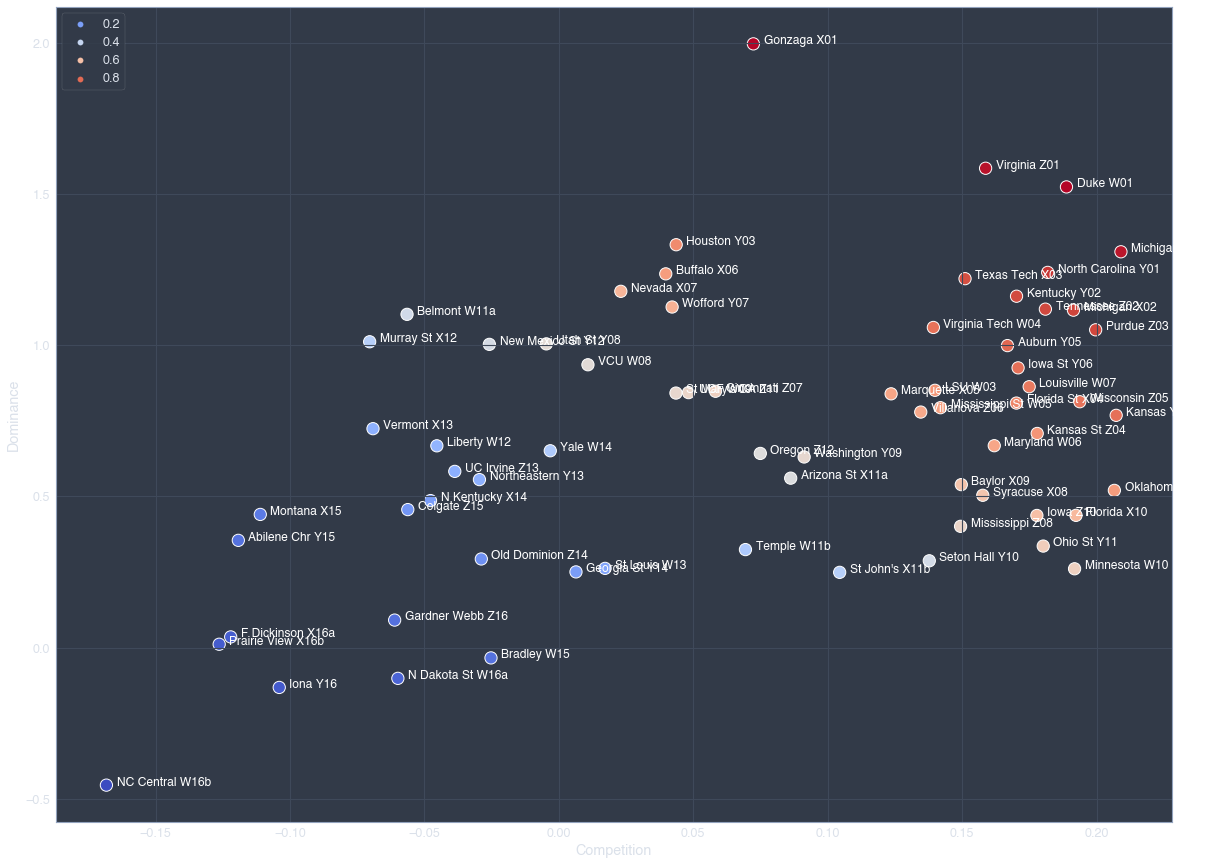

In [21]:
plt.figure(figsize=(20,15));
scatter_text(
    x=simulation_df["Competition"], y=simulation_df["Dominance"], s=150,
    hue=simulation_df["PowerRating"],
    palette=sns.color_palette("coolwarm", as_cmap=True),
    labelseries=simulation_df["TeamName"] + " " + simulation_df["Seed"],
    labelcolor="white",
);
plt.legend(loc='upper left');

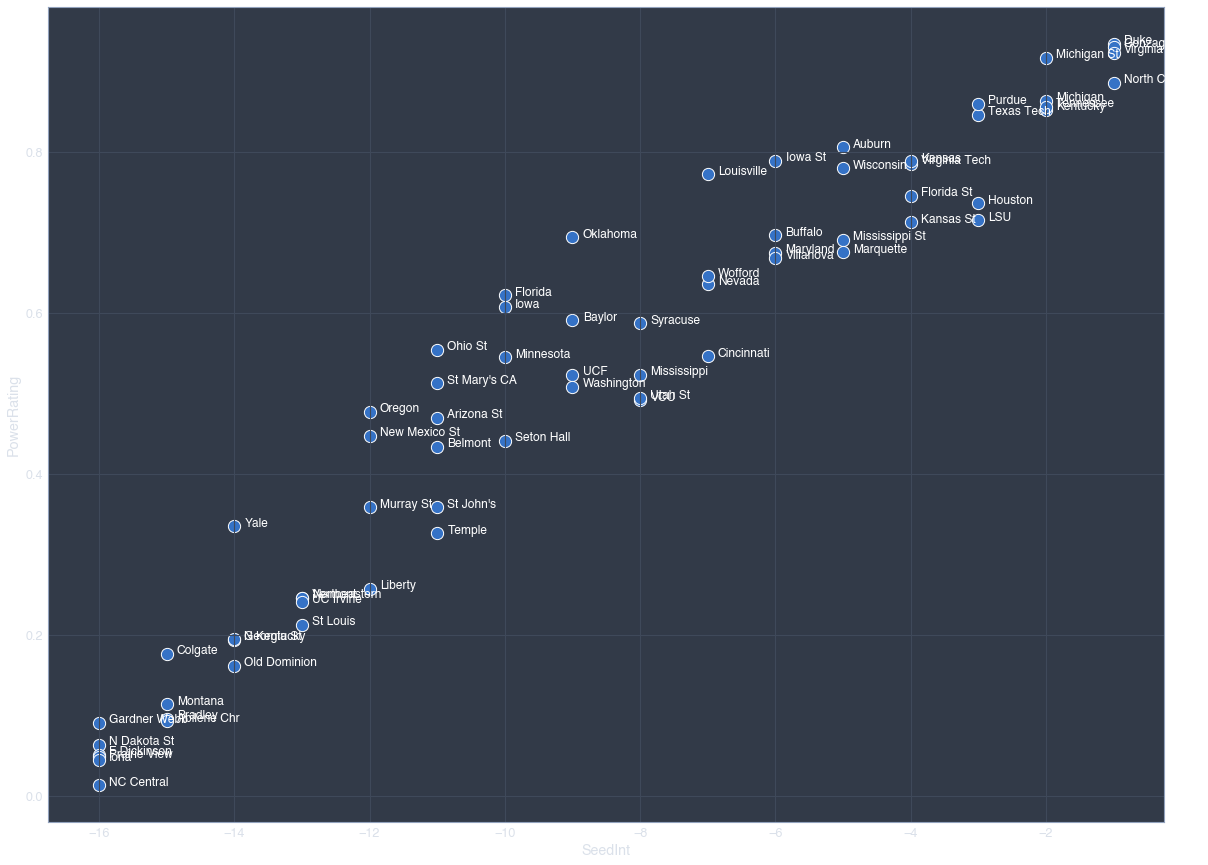

In [22]:
plt.figure(figsize=(20,15));
scatter_text(
    x=-simulation_df["SeedInt"],
    y=simulation_df["PowerRating"],
    s=150, labelseries=simulation_df["TeamName"], labelcolor="white",
);

In [23]:
BASIC_COLUMNS = ["TeamName", "Seed", "MeanWins", "PercentElite8", "PercentFinal4", "PercentChampion"]

In [24]:
# Who is the best team?
simulation_df.sort_values("PowerRating", ascending=False)[["PowerRating"] + BASIC_COLUMNS][:30]

,PowerRating,TeamName,Seed,MeanWins,PercentElite8,PercentFinal4,PercentChampion
8,0.934345,Duke,W01,3.6949,0.7667,0.4986,0.2039
22,0.931010,Gonzaga,X01,3.7358,0.7706,0.5527,0.1969
52,0.923060,Virginia,Z01,3.5284,0.6946,0.4764,0.1773
9,0.916988,Michigan St,W02,3.1222,0.6722,0.3558,0.1158
36,0.885947,North Carolina,Y01,3.1150,0.5923,0.3775,0.0787
23,0.863429,Michigan,X02,2.5022,0.4559,0.1900,0.0331
56,0.859618,Purdue,Z03,2.5216,0.4456,0.1977,0.0397
54,0.855798,Tennessee,Z02,2.4874,0.4264,0.1919,0.0352
38,0.852615,Kentucky,Y02,2.6751,0.5075,0.2588,0.0401
25,0.846488,Texas Tech,X03,2.2740,0.3852,0.1490,0.0213


In [25]:
# Who has the easiest schedule on average (excluding play ins)
is_not_play_in =  ~simulation_df["Seed"].str[-1].apply(str.isalpha)
simulation_df[is_not_play_in].sort_values(
    "AvgOppPower", ascending=True)[["AvgOppPower"] + BASIC_COLUMNS][:16]

,AvgOppPower,TeamName,Seed,MeanWins,PercentElite8,PercentFinal4,PercentChampion
36,0.544801,North Carolina,Y01,3.1150,0.5923,0.3775,0.0787
38,0.548022,Kentucky,Y02,2.6751,0.5075,0.2588,0.0401
40,0.549368,Houston,Y03,1.6269,0.1792,0.0615,0.0040
27,0.550464,Florida St,X04,1.6541,0.1245,0.0497,0.0034
58,0.555575,Kansas St,Z04,1.4305,0.0923,0.0294,0.0013
13,0.558286,Virginia Tech,W04,1.7690,0.1474,0.0536,0.0066
15,0.564088,Mississippi St,W05,1.3152,0.0670,0.0182,0.0007
11,0.568546,LSU,W03,1.4718,0.1173,0.0241,0.0013
23,0.568768,Michigan,X02,2.5022,0.4559,0.1900,0.0331
54,0.571609,Tennessee,Z02,2.4874,0.4264,0.1919,0.0352


In [26]:
# Who has the best chance to win
pie_df = simulation_df.sort_values("PercentChampion", ascending=False)
pie_df[[
    "TeamName", "Seed", "PowerRating", "AvgOppPower", "PercentElite8", "PercentFinal4", "PercentChampion"
]][:10]

,TeamName,Seed,PowerRating,AvgOppPower,PercentElite8,PercentFinal4,PercentChampion
8,Duke,W01,0.934345,0.578597,0.7667,0.4986,0.2039
22,Gonzaga,X01,0.931010,0.588187,0.7706,0.5527,0.1969
52,Virginia,Z01,0.923060,0.600913,0.6946,0.4764,0.1773
9,Michigan St,W02,0.916988,0.600189,0.6722,0.3558,0.1158
36,North Carolina,Y01,0.885947,0.544801,0.5923,0.3775,0.0787
38,Kentucky,Y02,0.852615,0.548022,0.5075,0.2588,0.0401
56,Purdue,Z03,0.859618,0.575918,0.4456,0.1977,0.0397
54,Tennessee,Z02,0.855798,0.571609,0.4264,0.1919,0.0352
23,Michigan,X02,0.863429,0.568768,0.4559,0.1900,0.0331
25,Texas Tech,X03,0.846488,0.580885,0.3852,0.1490,0.0213


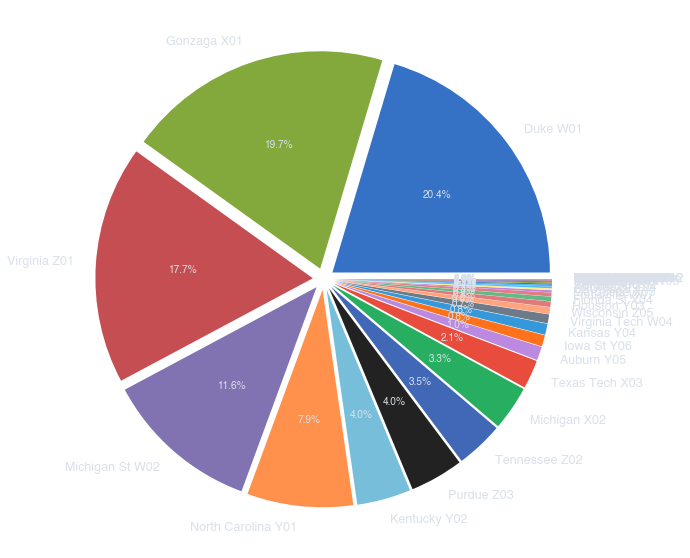

In [27]:
plt.figure(figsize=(10,10));
plt.pie(
    x=pie_df["PercentChampion"],
    labels=pie_df["TeamName"] + " " + pie_df["Seed"],
    autopct="%.1f%%",
    explode=[0.05]*len(simulation_df),
);

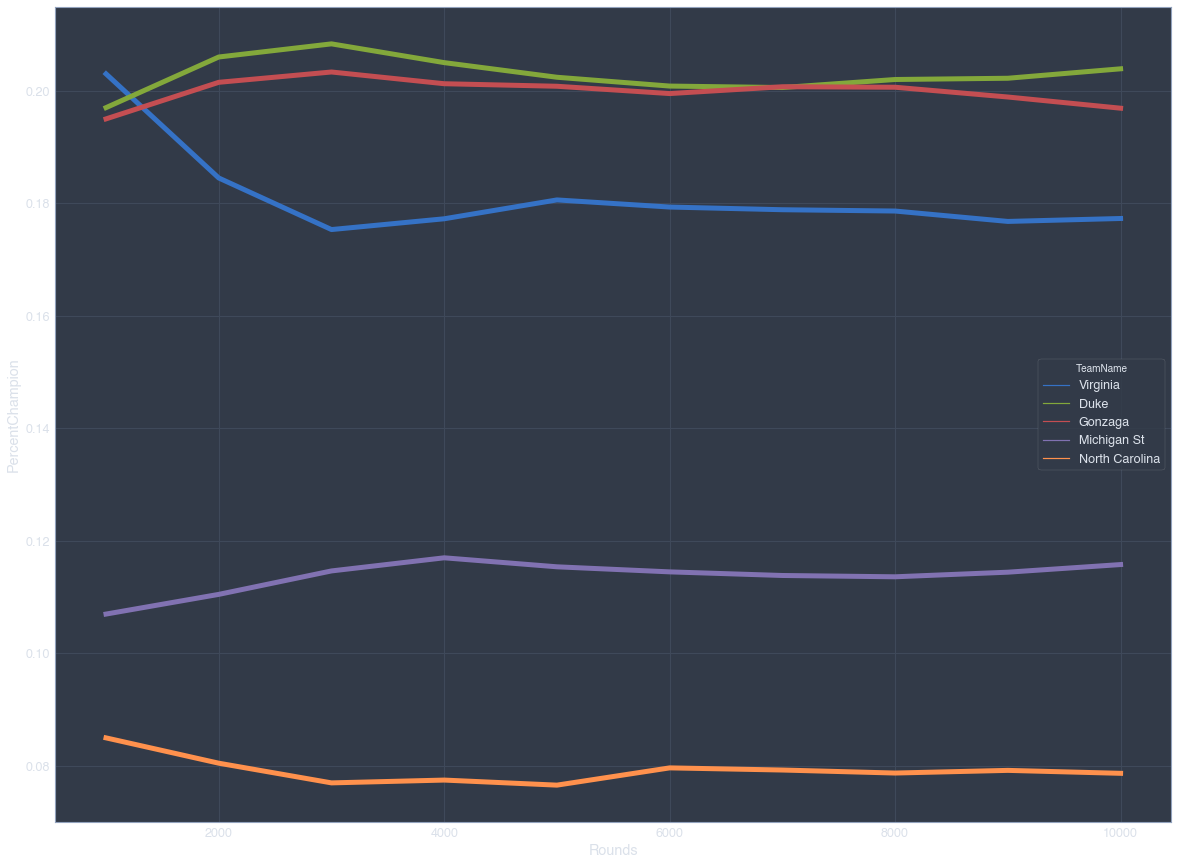

In [28]:
# Confirm % looks stable over time
plt.figure(figsize=(20,15));
progression_df = pd.DataFrame(simulation_progression).merge(
    tournament_df[["TeamID", "TeamName"]], on="TeamID"
)
sns.lineplot(
    data=progression_df,
    x="Rounds", y="PercentChampion", hue="TeamName", linewidth=5
);

In [29]:
 # What is the most common bracket?
bracket_slots = []
for slot, win_dict in slots_wins.items():
    top_teams = sorted(((v, k) for k, v in win_dict.items()), reverse=True)
    max_count, max_team_id = top_teams[0]
    runner_count, runner_team_id = top_teams[1]
    total = sum(v for v in win_dict.values())
    bracket_slots.append({
        "Slot": slot,
        "WinTeamID": max_team_id,
        "WinPct": max_count / total,
        "RunnerTeamID": runner_team_id,
        "RunnerWinPct": runner_count / total,
    })

bracket_df = pd.DataFrame(bracket_slots).merge(
    tournament_df[["TeamID", "TeamName", "Seed"]], left_on="WinTeamID", right_on="TeamID"
).rename(columns={"TeamName": "WinTeamName", "Seed": "WinSeed"}).merge(
    tournament_df[["TeamID", "TeamName", "Seed"]], left_on="RunnerTeamID", right_on="TeamID"
).rename(columns={"TeamName": "RunnerTeamName", "Seed": "RunnerSeed"})
bracket_df["Round"] = bracket_df["Slot"].apply(lambda x: int(x[1]) if x.startswith("R") else 0)
bracket_df = bracket_df[[
    "Slot", "Round",
    "WinTeamName", "WinSeed", "WinPct",
    "RunnerTeamName", "RunnerSeed", "RunnerWinPct"
]]

In [30]:
bracket_df[bracket_df["Round"] == 5].sort_values("WinPct", ascending=False)

,Slot,Round,WinTeamName,WinSeed,WinPct,RunnerTeamName,RunnerSeed,RunnerWinPct
55,R5YZ,5,Virginia,Z01,0.3300,North Carolina,Y01,0.1897
25,R5WX,5,Gonzaga,X01,0.3141,Duke,W01,0.3030


In [31]:
# Submit to Kaggle
import itertools
predictions = []
for year in range(2015, 2020):
    submit_df = raw_tournament_df[raw_tournament_df["Season"] == year].set_index(["Season", "TeamID"])
    ids = sorted(submit_df.loc[year].index)
    for id_a, id_b in itertools.product(ids, ids):
        if id_a >= id_b:
            continue
        team_a = submit_df.loc[(year, id_a)]
        team_b = submit_df.loc[(year, id_b)]
        predict_data = (
            team_a["OwnScore_Zscore"], team_b["OwnScore_Zscore"],
            team_a["OppScore_Zscore"], team_b["OppScore_Zscore"],
            team_a["OffCompetition"], team_b["OffCompetition"],
            team_a["DefCompetition"], team_b["DefCompetition"],
        )
        prob = calc_prob(predict_data)
        predictions.append({
            "ID": f"{year}_{id_a}_{id_b}",
            "Pred": prob
        })

In [32]:
pred_df = pd.DataFrame(predictions)
pred_df.to_csv(f"{DATA_DIR}/output/kaggle_submission.csv", index=False)